In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from scipy import stats
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW
import astropy.units as u

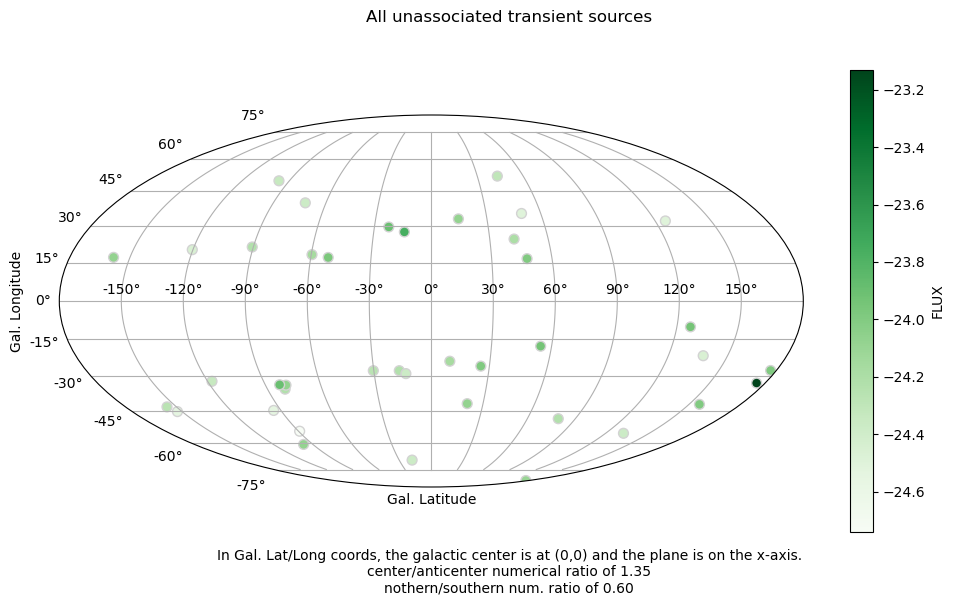

In [7]:
def generate_mollweise(targets, cmap_var = 'TS', log_cmap = False, calculate_isotropy=True):

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111, projection='mollweide')
    plt.grid(True)

    # change the >180s to negative
    modified = targets.copy()
    modified.loc[modified['LII']>180, 'LII'] -= (360)
    
    if log_cmap is True:
        modified[cmap_var] = np.log(modified[cmap_var])
    sc = ax.scatter(modified['LII']*(np.pi/180), targets['BII']*(np.pi/180), 50, 
                c=modified[cmap_var], cmap='Greens', edgecolors='lightgray')
    plt.colorbar(sc, label = cmap_var)

    ax.set_ylabel('Gal. Longitude')
    ax.set_xlabel('Gal. Latitude')

    caption = 'In Gal. Lat/Long coords, the galactic center is at (0,0) and the plane is on the x-axis.'
    
    if calculate_isotropy:
        #### TODO
        center = modified.query('LII > -90 and LII < 90').shape[0]
        anticenter = modified.query('LII > 90 or LII < -90').shape[0]
        caption += '\ncenter/anticenter numerical ratio of %.2f'%(center/anticenter)
        northern = modified.query('BII > 0 and BII < 90').shape[0]
        southern = modified.query('BII < 0 and BII > -90').shape[0]
        caption += '\nnothern/southern num. ratio of %.2f'%(northern/southern)
    
    plt.figtext(0.5, 0.01, 
                caption, 
                horizontalalignment='center', fontsize=10)
    return fig

# Import Unassociated Transients
targets = pd.read_csv('./correct_unassociated/FERMILTRNSUnassociated.csv')#'./UnassocTransientsCatalog.csv')
# targets.columns = targets.columns.str.strip(' ') # Clean columns
# targets['SRCNumber'] = targets['SRCNumber'].str.strip(' ').str.strip('"') # Clean SRCNumber
# targets['LII'] = targets['LII'].str.strip('" * "').astype('float') # Clean galactic coords
# targets['BII'] = targets['BII'].str.strip('" * "').astype('float')

fig = generate_mollweise(targets, cmap_var='FLUX', log_cmap=True, calculate_isotropy=True)
fig.suptitle('All unassociated transient sources')
fig.savefig('TransientsIsotropy.png')

In [8]:
# Collect files
datasets = glob.glob('./correct_unassociated/apjsac*.csv')

# Track SRCNumber
filename = []
filenumber = []

library = {} # key = filename, val = pd.DataFrame
for file in datasets:
    # Read in data for each file
    library[file] = pd.read_csv(file, header=None)
    
    # Track SRCNumber
    filename.append(file)
    filenumber.append( int(file.split('_')[2]) )

# Create pd for file:SRCNumbers
filename_to_filenumber = pd.DataFrame({'filename': filename, 'filenumber': filenumber})

In [9]:
# Merge datasets on IMG file number
targets = targets.merge(right = filename_to_filenumber, how = 'outer', left_on = 'IMG_NUMBER', right_on = 'filenumber')

In [10]:
# Reformat datasets
def reformat_datasets(library):
    reformat = {}

    for key in library:

        # For each dataset
        d = library[key]
        x = []
        y = []
        yerr = []
        # For each row
        for i in range(d.shape[0]):
            # Odds are data, evens are upper/lower error bound
            if i % 2:
                yerr.append(d.iloc[i,1])
            else:
                x.append(d.iloc[i,0])
                y.append(d.iloc[i,1])

        # Make error always positive
        yerr = np.abs(np.array(y) - np.array(yerr))

        # Reformat pd appropriately
        reformat[key] = pd.DataFrame( {'MJD':x, 'Fl (E>100MeV)e-8 cm-2 s-1':y, 'Error':yerr} )

    return reformat

library = reformat_datasets(library)



/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in power
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in p

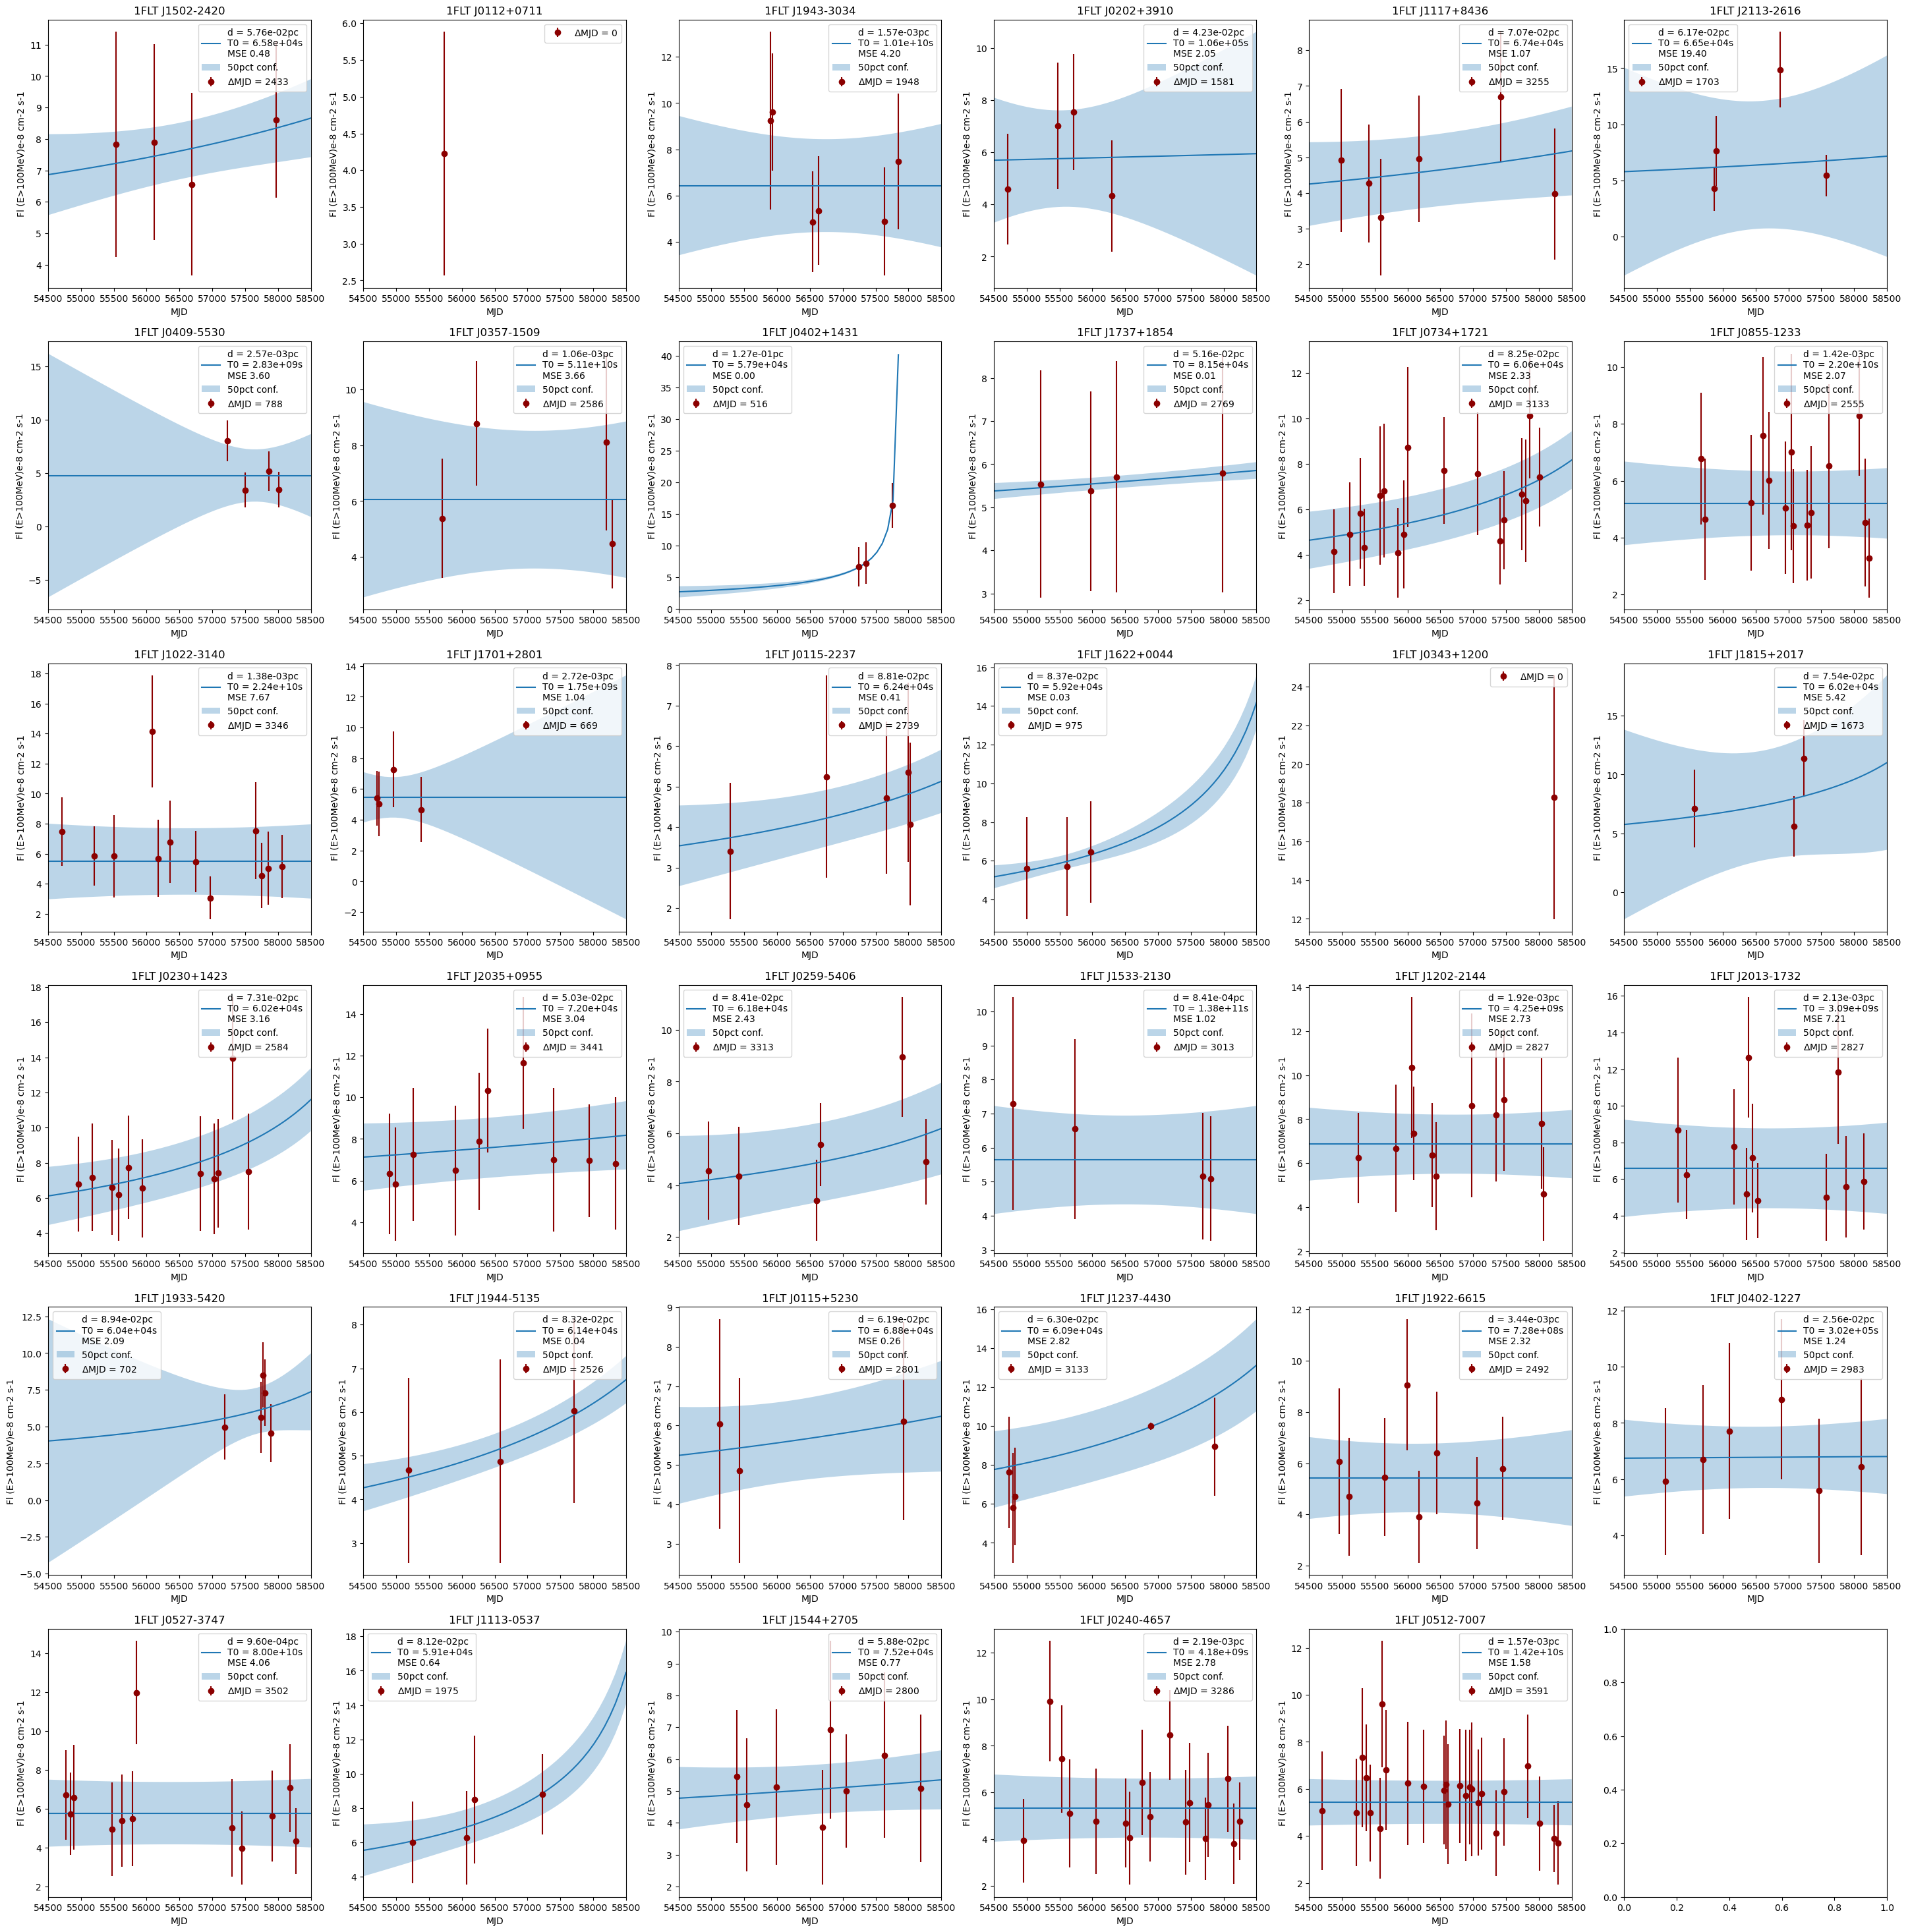

In [11]:
# model = lambda x,A,T0: A * (T0 - x)**(-.53) #lambda x,m,b: m*x + b
model = lambda x,A,T0: 10**A * (10**T0 - x)**(-.53)

fig, axes = plt.subplots(6,6, figsize=(36,37))
ax = axes.flatten()

fit_results = {}

for i,key in enumerate(library):

    d = library[key]

    x = d['MJD']
    y = d['Fl (E>100MeV)e-8 cm-2 s-1']
    yerr = d['Error']

    # Plot datapoints
    ax[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred', label = r'$\Delta$MJD = %i'%(x.iloc[-1] - x.iloc[0]))
    
    # Curve fitting
    if x.shape[0]>1: # If there's >1 datapoint
        coefs, cov = curve_fit(f = model, xdata = x, ydata = y, sigma = yerr, p0 = [
            3, 5#(y.iloc[-1] - y.iloc[0])/(x.iloc[-1] - x.iloc[0]), # slope
            #(x.iloc[0]) # intercept
        ], bounds = (
            [2, 4], # lower bounds
            [7, 18]  # upper bounds
        )
        )

        # Plot the data and the fitted curve
        xaxis = np.linspace(54500, 58500)
        y_model = model(xaxis, coefs[0], coefs[1])

        # Calculate distance
        distance_A = lambda A: np.sqrt(3.2 / A)

        ax[i].plot(xaxis, y_model, '-', label = 'd = %.2epc\nT0 = %.2es\nMSE %.2f'%(distance_A(10**coefs[0]), 10**coefs[1], mean_squared_error(y, model(x, *coefs))))

        # Compute std for each coef
        a_err, b_err = 10**np.sqrt(np.diag(cov))

        # Compute the confidence interval for the fitted curve
        n = len(y)
        p = len(coefs)
        dof = max(0, n - p)  # degrees of freedom
        t = stats.t.ppf(0.5 / 2., dof) # 50% confidence interval

        # Sample standard deviation 
        # if (y - yerr) < model < (y + yerr): error is 0
        # otherwise base the error on the extreme of the errorbar i.e.
        # gaussian likelihood[ y + yerr - model() ]
        s_err = np.sqrt(
            np.sum((y - model( x, *coefs )) ** 2) / dof
            )

        # https://www.scribbr.com/statistics/confidence-interval/
        # https://tomholderness.wordpress.com/2013/01/10/confidence_intervals/
        y_fit_upper = y_model + t * s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        y_fit_lower = y_model - t * s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

        ax[i].fill_between(xaxis, y_fit_lower, y_fit_upper, alpha=0.3, label='50pct conf.')

        fit_results[key] = {'Coefs':10**coefs, 'Cov':10**cov, 'Serr':10**s_err}

    ax[i].set_xlim(54500, 58500)

    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    ax[i].set_title(targets.query('filename == @key').iloc[0].NAME[2:-1])
    ax[i].legend()


# fig.savefig('TransientSourceFits_T0>>DeltaT.png', dpi=500)
# fig.savefig('TransientSourceFits_T0>>DeltaT_lowres.png')
fig.savefig('TransientSourceFits_logsFit.png')

In [12]:
def remaining_mass(T0, 
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s
    ):
    """
    Input T0 in seconds;
    return mass in grams
    """
    return (3 * alpha * T0)**(1/3) # Eqn. 7 of Nature article

def remaining_time(mass,
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s)
    ):
    """
    Inverse of last eqn.
    """
    return (mass)**(3) / (3*alpha)

In [13]:
# Unpack results for merging to targets
filenames = []
T0 = []
T0_error = []
distance = []
distance_error = []
std_error = []
for file in fit_results:
    filenames.append(file)

    # Returns as A, T0
    a,b = fit_results[file]['Coefs']
    T0.append(b)
    distance.append( distance_A(a) )

    a_err, b_err = np.diagonal(fit_results[file]['Cov'])
    T0_error.append(a_err)
    distance_error.append(distance_A(b_err))

    std = fit_results[file]['Serr']
    std_error.append(std)

# Make the df for params
targets = targets.merge( right = pd.DataFrame({
    'filename': filenames,
    'T0': np.array(T0) - 54500,
    'T0_error': T0_error,
    'distance': distance,
    'distance_error': distance_error,
    'std_error': std_error
}), on='filename', how = 'outer').sort_values('SOURCE_NUMBER')

In [14]:
# targets.to_csv('TransientSources_fitted_params.csv')
# targets

In [15]:
# From ../Modelling/Analytical_Modelling.ipynb

def logNormalMassFcn(sigma, Mstar, M):
    return np.exp(
        -np.log(M/Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * M)

fPBH = 1e-8
gramsperGeV = 1 / (5.6095886*1e23)
rhoDM = 0.4 * gramsperGeV * (u.pc.to('cm')**3)

def numberDensity(mass, distance, Mstar = 1e10, sigma = 1):
    return  logNormalMassFcn(sigma, Mstar, mass) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/Users/xboluna/opt/miniconda3/envs/threeML/lib/p

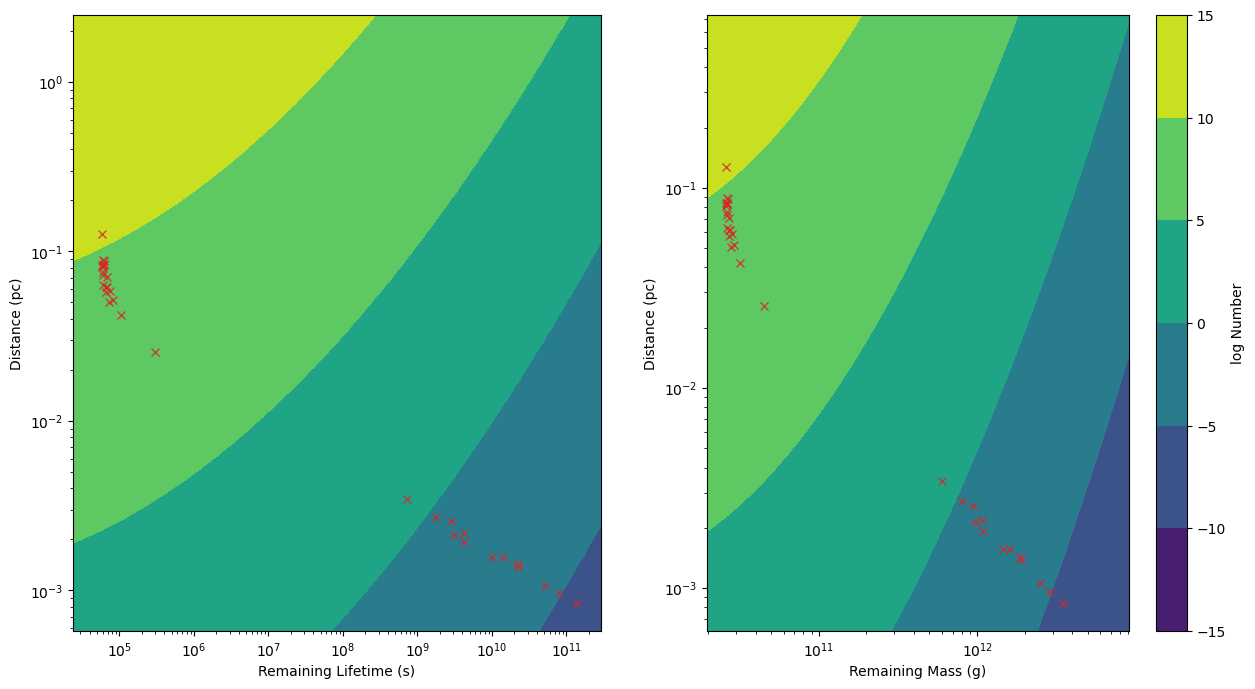

In [28]:
fig, axes = plt.subplots(1,2, figsize = (15,8))

ax = axes[0]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    # A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))
    A_std = T0_std = fit_results[key]['Serr']

    d = distance_A(A)
    d_std = distance_A(A_std)
    ax.errorbar(x = T0, xerr = T0_std, y = d, yerr = d_std, fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.8, zorder = 1)

# ax.set_xlabel('Norm (1/pc^2)')
ax.set_ylabel('Distance (pc)')
ax.set_xlabel('Remaining Lifetime (s)')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e4,1e12)

###
time = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]))
mass = remaining_mass(time)
distance = np.logspace(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]))
M,D = np.meshgrid(mass, distance)
T,D = np.meshgrid(time, distance)

sigma = 1
Mstar = 1e10

cont = ax.contourf( T, D, np.log10(numberDensity(M,D,Mstar,sigma)) , levels = [-15, -10, -5, 0, 5, 10, 15] )
cb = fig.colorbar(cont, label = 'log Number')
###

# yrange = np.logspace(*np.log10(ax.get_ylim())) # s
# xrange = np.logspace(*np.log10(ax.get_xlim())) # pc
# X,Y = np.meshgrid(xrange, yrange)

# < 4/3 pi * rhoDM * (dist ^ 3) / (lifetime / 3e7s)
lim = lambda X,Y: (4*3.14159/3) * (3400) / ( X**3 ) / (Y*3e-7)

# cntr = ax.contour(np.flip(xrange),np.flip(yrange), np.log10(lim(X,Y)), [-5,0,5,10,15,20], cmap = 'cividis', alpha=1)#np.arange(-4,17)
# ax.clabel(cntr, fmt="%i", use_clabeltext=True, fontsize = 20)


###########
ax = axes[1]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    # A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))
    A_std = T0_std = 10**fit_results[key]['Serr']

    d = distance_A(A)
    d_std = distance_A(A_std)

    mass = remaining_mass(T0)
    mass_std = remaining_mass(T0)
    ax.errorbar(x = mass, xerr = mass_std, y = d, yerr = d_std, fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.8, zorder = 1)

ax.set_ylabel('Distance (pc)')
ax.set_xlabel('Remaining Mass (g)')
ax.set_yscale('log')
ax.set_xscale('log')

###
mass = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]))
distance = np.logspace(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]))
M,D = np.meshgrid(mass, distance)

sigma = 1
Mstar = 1e10

cont = ax.contourf( M, D, np.log10(numberDensity(M,D,Mstar,sigma)) , levels = [-15, -10, -5, 0, 5, 10, 15] )
#cb = fig.colorbar(cont, label = 'log Number')
###


# yrange = np.logspace(*np.log10(ax.get_ylim())) # s
# xrange = np.logspace(*np.log10(ax.get_xlim())) # pc
# X,Y = np.meshgrid(xrange, yrange)

# cntr = ax.contour(np.flip(xrange),np.flip(yrange), np.log10(lim(X,remaining_time(Y))), [-5,0,5,10,15,20], cmap = 'cividis', alpha=1)#np.arange(-4,17)
# ax.clabel(cntr, fmt="%i", use_clabeltext=True, fontsize = 20)

fig.savefig('TransientsDistribution.png')